In [2]:
import numpy as np
import pandas as pd
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE


In [3]:
train = pd.read_csv("cleaned_train.csv")
test = pd.read_csv("cleaned_test.csv")
ids = test["id"]

In [38]:

def train_multinomial_logistic_regression(data, test, target_column, test_size=0.2, random_state=42):
    """
    Trains a multinomial logistic regression classifier and evaluates its performance.
    """

    X = data.drop([target_column, 'id'], axis=1)
    y = data[target_column]
    y = y.astype(np.uint8)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Apply SMOTE to the training data
    smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances the classes
    X_train, y_train = smote.fit_resample(X_train, y_train)

    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }

    # Create a multinomial logistic regression classifier
    classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

    # Set up Stratified K-Fold
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Create GridSearchCV
    grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=stratified_kfold, n_jobs=-1)

    # Train the classifier on the training data using GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best estimator from GridSearchCV
    classifier = grid_search.best_estimator_

    # Get feature importances for logistic regression
    importances = classifier.coef_[0]

    # Get the names of the features
    feature_names = X.columns

    # Sort features based on importance
    sorted_idx = importances.argsort()[::-1]

    # Select the top 50 features
    top_features_idx = sorted_idx[:50]

    # Plot feature importances
    plt.figure(figsize=(15, 8))
    plt.barh(range(len(top_features_idx)), importances[top_features_idx], align="center")
    plt.yticks(range(len(top_features_idx)), [feature_names[i] for i in top_features_idx])
    plt.xlabel("Logistic Regression Feature Importance")
    plt.title("Feature Importance - Logistic Regression")
    plt.show()

    # Make predictions on the test set
    y_pred = classifier.predict(X_test).clip(0, 5).round()

    # Evaluate the performance of the classifier
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average="weighted")

    # Print the confusion matrix
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)

    # Print the classification report
    class_report = metrics.classification_report(y_test, y_pred)

    # Make predictions on the final test set
    test = test.drop("id", axis=1)
    y_test_final = classifier.predict(test).clip(0, 5).round()
    y_train_predicted = classifier.predict(X).clip(0, 5).round()

    return classifier, accuracy,f1, conf_matrix, class_report, y_test_final, y_train_predicted

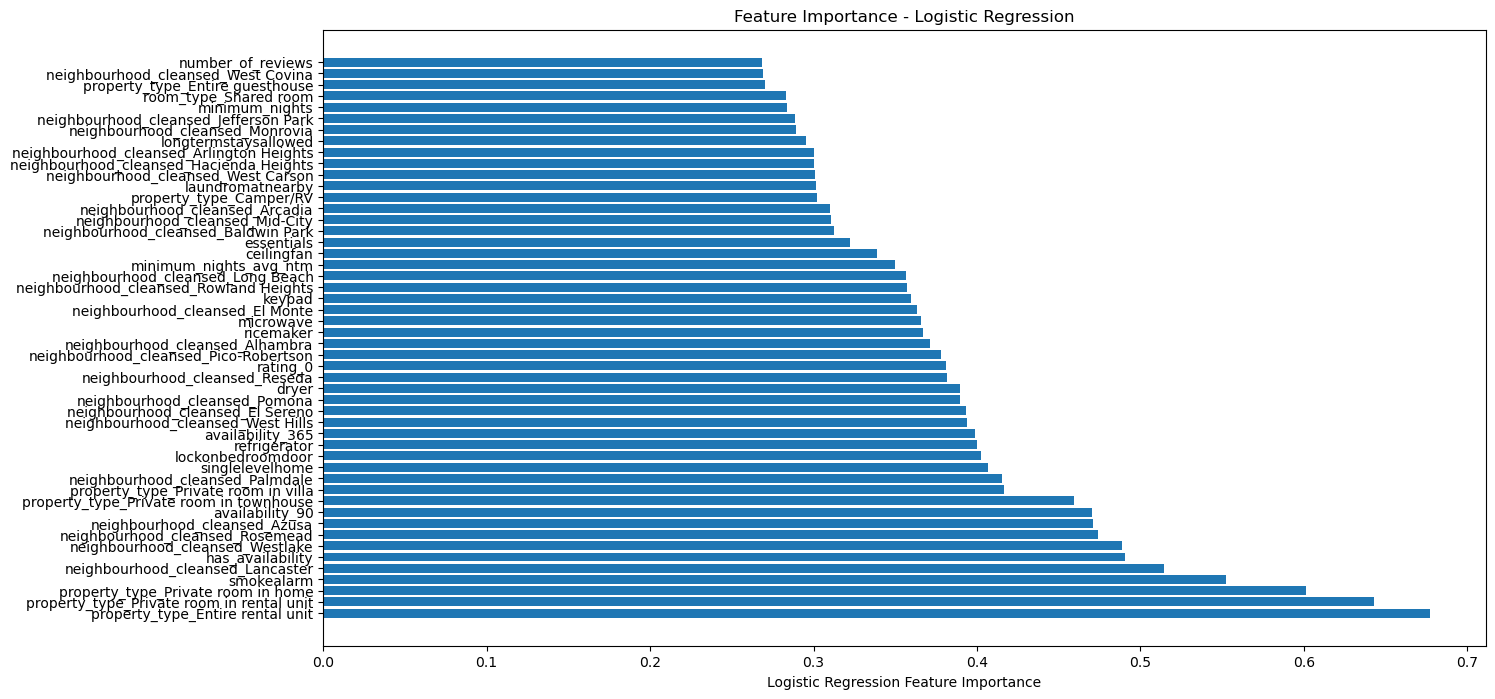

In [39]:
classifier, accuracy, f1, conf_matrix, class_report, y_test_final, y_train_predicted = train_multinomial_logistic_regression(train, test, "price", test_size=0.2, random_state=42)

In [46]:
print(accuracy)
print(f1)

0.5079313693752023
0.4986208127531645


In [40]:
# Draws a paramater vs. accuracy graph for a given parameter for Logistic Regression
def train_LR_param_graph(data, parameter, target_column, n_folds=5, test_size=0.2, random_state=19):
    
    X = data.drop([target_column, 'id'], axis=1)
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Apply SMOTE to the training data
    smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances the classes
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2']
    }

    values = param_grid[parameter]

    # Lists to store accuracy values and corresponding parameter values
    accuracy_values = []
    parameter_values = []

    # iterating over all param values
    for param in values:

        classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=param, max_iter=1000)

        classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test).clip(0,5).round()

        # Evaluate the performance of the best classifier
        accuracy = metrics.accuracy_score(y_test, y_pred)

        # Append accuracy and parameter value to the lists
        accuracy_values.append(accuracy)
        parameter_values.append(param)

    # Plotting the chart
    plt.figure(figsize=(8, 6))
    plt.plot(parameter_values, accuracy_values, marker='o')
    plt.title(f'{parameter} vs. Accuracy')
    plt.xlabel(f'{parameter}')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return plt


In [42]:
# THIS DIDN'T WORK
# test['LR_predictions'] = y_test_final
# train['LR_predictions'] = y_train_predicted

# # Assuming LR_predictions is a DataFrame column
# LR_predictions_train = train['LR_predictions'].values.reshape(-1, 1)
# LR_predictions_test = test['LR_predictions'].values.reshape(-1, 1)

# # Min-max scale numerical columns
# scaler = MinMaxScaler()
# train['LR_predictions'] = scaler.fit_transform(LR_predictions_train)
# test['LR_predictions'] = scaler.transform(LR_predictions_test)

# test.to_csv("test_LRpred.csv")
# train.to_csv("train_LRpred.csv")

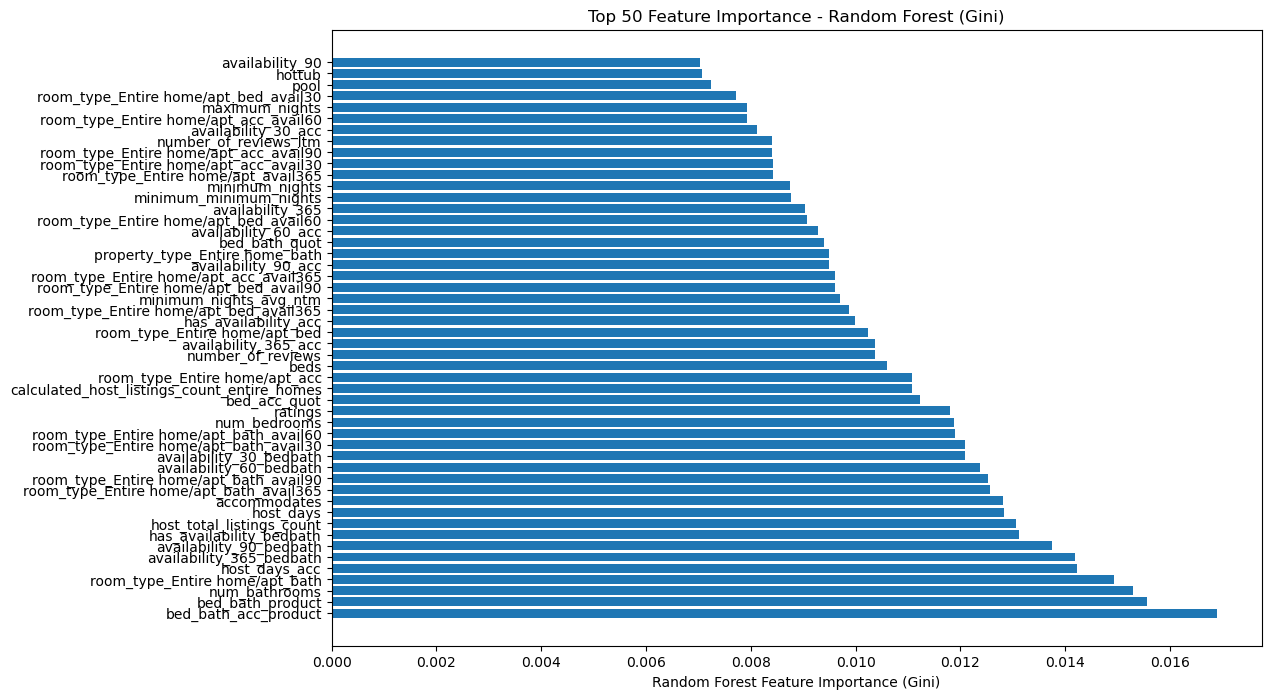

Final Accuracy:  0.5516348332793785
Final F1:  0.5445848536617328


In [8]:
def train_random_forest(data, test, target_column, n_folds=5, test_size=0.2, random_state=19):
    """
    Trains a Random Forest classifier and evaluates its performance.
    """

    # defining a custom accuracy measure that would help round and then get the acuracy score
    def custom_accuracy(y_true, y_pred):
        rounded_preds = np.round(y_pred.clip(0, 5))
        return metrics.accuracy_score(y_true, rounded_preds)

    # Make the scorer function
    custom_accuracy_scorer = metrics.make_scorer(custom_accuracy, greater_is_better=True)

    X = data.drop([target_column, 'id'], axis=1)
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # # Apply SMOTE to the training data
    smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances the classes
    X_train, y_train = smote.fit_resample(X_train, y_train)


    # Create a Random Forest classifier
    classifier = RandomForestClassifier(n_estimators=500, random_state=random_state)

    param_grid = {
        # 'n_estimators': [10, 20, 50, 70, 100, 250, 500],
        # 'max_depth': [None, 3, 5, 7, 9, 10, 12, 15],
        # 'min_samples_split': [2, 5, 7, 10],
        # 'min_samples_leaf': [1, 2, 4, 5, 10],
        }

    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

    # Create GridSearchCV
    grid_search = GridSearchCV(classifier, param_grid, cv=stratified_kfold, scoring=custom_accuracy_scorer)

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get the best estimator
    best_classifier = grid_search.best_estimator_

    # Get feature importances from Gini importance
    importances_gini = best_classifier.feature_importances_

    # Sort features based on importance
    sorted_idx = importances_gini.argsort()[::-1]

    # Select the top 100 features
    top_features_idx = sorted_idx[:50]

    # Plot top 50 feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features_idx)), importances_gini[top_features_idx], align="center")
    plt.yticks(range(len(top_features_idx)), [X.columns[i] for i in top_features_idx])
    plt.xlabel("Random Forest Feature Importance (Gini)")
    plt.title("Top 50 Feature Importance - Random Forest (Gini)")
    plt.show()

    # Make predictions on the test set
    y_pred = best_classifier.predict(X_test).clip(0, 5).round()

    # Evaluate the performance of the best classifier
    print("Final Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    print("Final F1: ", metrics.f1_score(y_test, y_pred, average="weighted"))

    # Make predictions on the final test set
    test = test.drop("id", axis=1)
    y_final = best_classifier.predict(test).clip(0, 5).round()
    y_train_predicted = best_classifier.predict(X).clip(0, 5).round()

    return y_pred, y_test, y_final, best_classifier, importances_gini, y_final, y_train_predicted

y_pred, y_test, y_final, best_classifier, importances_gini, y_final, y_train_predicted = train_random_forest(train, test, "price")
# print(f"Accuracy: {accuracy:.2f}")

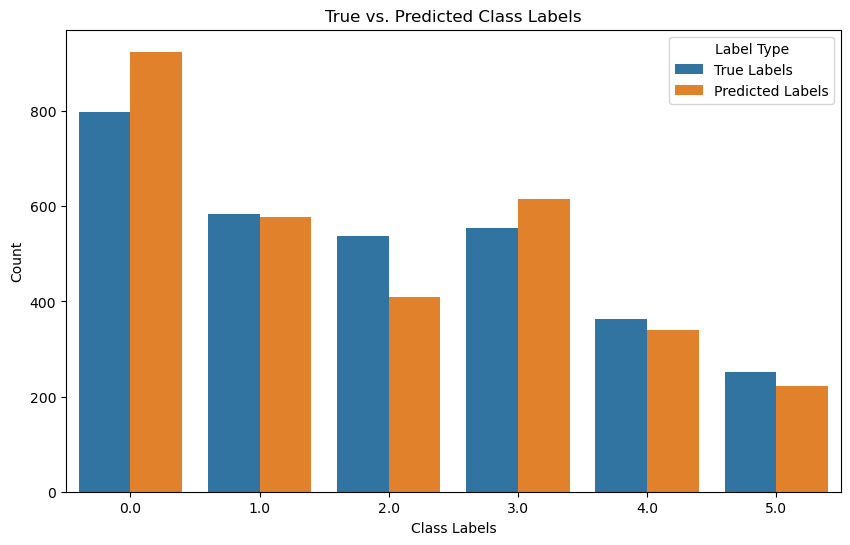

In [9]:
import seaborn as sns

# Create a DataFrame with the true and predicted labels
df = pd.DataFrame({'True Labels': y_test, 'Predicted Labels': y_pred})

# Melt the DataFrame to long format
df_melted = pd.melt(df, var_name='Label Type', value_name='Label')

# Plot a side-by-side bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', hue='Label Type', data=df_melted)
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('True vs. Predicted Class Labels')
plt.legend(title='Label Type')
plt.show()


In [ ]:
# Draws a paramater vs. accuracy graph for a given parameter for Random Forest

def train_random_forest_param_graph(data, parameter, target_column, n_folds=5, test_size=0.2, random_state=19):
    
    def custom_accuracy(y_true, y_pred):
        rounded_preds = np.round(y_pred.clip(0, 5))
        return metrics.accuracy_score(y_true, rounded_preds)

    # Make the scorer function
    custom_accuracy_scorer = metrics.make_scorer(custom_accuracy, greater_is_better=True)

    X = data.drop([target_column, 'id'], axis=1)
    y = data[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Apply SMOTE to the training data
    smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' balances the classes
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Create a Random Forest classifier
    classifier = RandomForestRegressor(random_state=random_state)
    # classifier = RandomForestClassifier(n_estimators=500, random_state=random_state)


    # Define a range of values for the parameter you want to vary (e.g., min_samples_leaf)
    param_grid = {
        'n_estimators': [10, 20, 50, 70, 100, 250, 500],
        'max_depth': [None, 3, 5, 7, 9, 10, 12, 15],
        'min_samples_split': [2, 5, 7, 10],
        'min_samples_leaf': [1, 2, 4, 5, 10],
        }

    values = param_grid[parameter]

    # Lists to store accuracy values and corresponding parameter values
    accuracy_values = []
    parameter_values = []

    for param in values:
        # Update the param_grid with the current param value
        param_grid = {}
        param_grid[parameter] = [param]
    
        classifier = RandomForestClassifier(max_depth=param, random_state=random_state)

        classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = classifier.predict(X_test)#.clip(0,5).round()

        # Evaluate the performance of the best classifier
        accuracy = metrics.accuracy_score(y_test, y_pred)

        # Append accuracy and parameter value to the lists
        accuracy_values.append(accuracy)
        parameter_values.append(param)

    # Plotting the chart
    plt.figure(figsize=(8, 6))
    plt.plot(parameter_values, accuracy_values, marker='o')
    plt.title(f'{parameter} vs. Accuracy')
    plt.xlabel(f'{parameter}')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    return plt


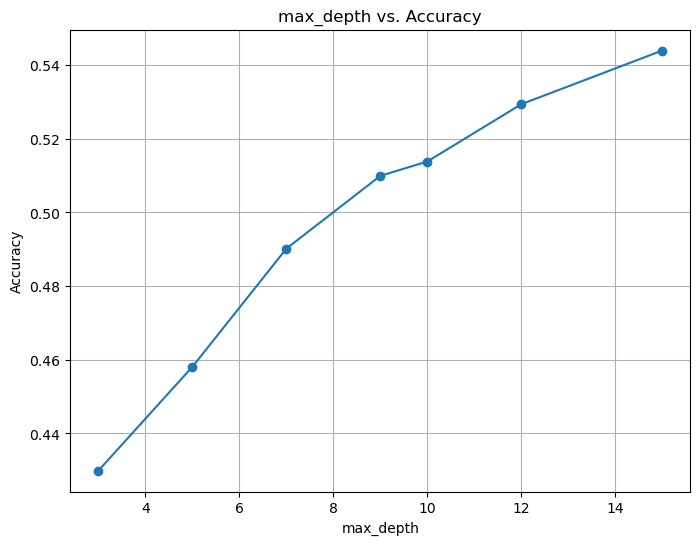

In [ ]:
# paramplot = train_random_forest_param_graph(train, 'max_depth', "price")
